In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# ↓ DATA PREPARATION AND ORIGINAL SERIES VISUALIZATION

Cleaning the dataset by dealing with missing values, eliminating outliers, and guaranteeing consistency in time intervals are all part of proper data preparation.  Because data errors or inconsistencies can result in skewed or incorrect forecasts, this step is crucial.  Additionally, the model is better able to capture patterns when the data is transformed, such as by applying differencing to make the series stationary. The behavior of the data over time, however, can be clearly understood with original series visualization.  Analysts can find key patterns like trends, seasonality, and anomalies by charting the raw time series.  Choosing the right forecasting model (such as ARIMA for stationary data or SARIMA for seasonal data) and adjusting model parameters are made easier with the aid of this visual inspection.


In [ ]:
# 1. Load the data and Prepare
df = pd.read_csv('Initial_merged_dataset.csv')

df.head

<bound method NDFrame.head of       Transaction_ID Company_ID       Product_ID Transaction_Date  \
0                  1       88.0              6.0       2024-03-26   
1                  2       29.0             19.0       2024-07-09   
2                  3       28.0             18.0       2024-04-13   
3                  4       85.0             12.0       2023-09-06   
4                  5       47.0             15.0       2021-07-06   
...              ...        ...              ...              ...   
9995            9996    Unknown             10.0       2022-06-05   
9996            9997       39.0             17.0       2021-05-17   
9997            9998       90.0              1.0       2022-07-19   
9998            9999       33.0  Unknown Product       2021-04-15   
9999            9999       77.0             16.0       2023-10-29   

      Product_Price  Quantity  Total_Cost            Product_Name  \
0     179200.000000       6.0   1075200.0    RevenueVue Dashboard   
1  

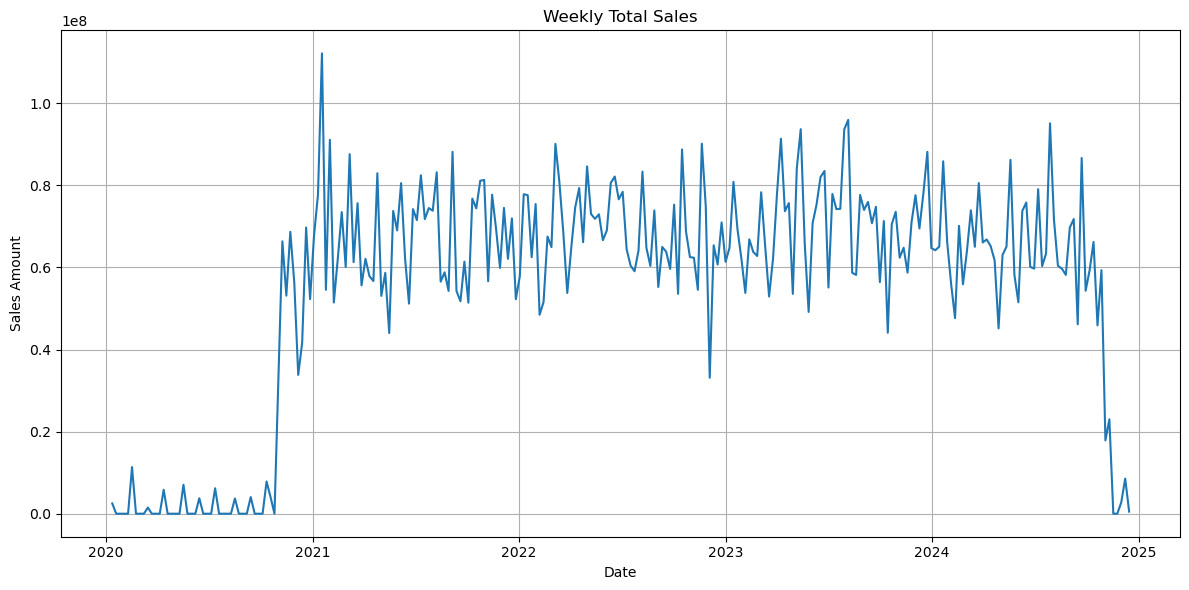

In [ ]:
# Convert date to datetime format
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

# Sort by date
df = df.sort_values('Transaction_Date')

# Create time series by aggregating sales by week
ts = df.set_index('Transaction_Date')['Total_Cost'].resample('W').sum()

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Weekly Total Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Check missing
missing_values = df.isna().sum()
print("\nMissing values per column before handling:")
print(missing_values)

# Check for duplicates
duplicate_rows = df.duplicated().sum()
print("\nDuplicated Rows:")
print(duplicate_rows)


Missing values per column before handling:
Transaction_ID      0
Company_ID          0
Product_ID          0
Transaction_Date    0
Product_Price       0
Quantity            0
Total_Cost          0
Product_Name        0
Company_Name        0
Company_Profit      0
Address             0
dtype: int64

Duplicated Rows:
0


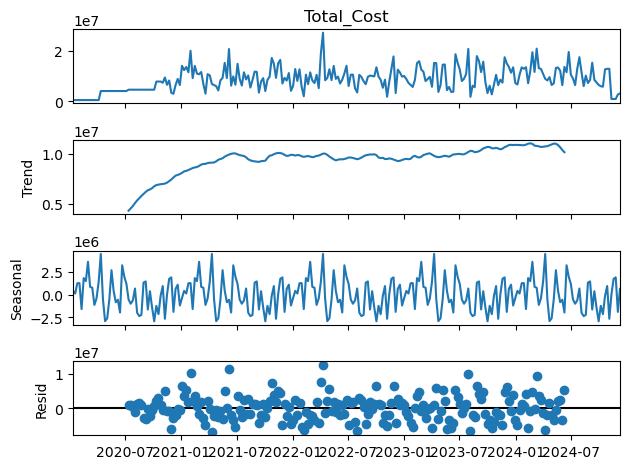

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ensure 'Date' is in datetime format and set as index
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df.set_index('Transaction_Date', inplace=True)

# Step 1: Handle duplicate dates by aggregating (e.g., sum the values)
df = df.groupby(df.index).sum()

# Step 2: Ensure data is sorted by date
df.sort_index(inplace=True)

# Step 3: Set frequency to weekly and fill any missing values
df = df.asfreq('W')  # 'W' ensures weekly frequency
df.ffill(inplace=True)  # Forward fill missing data

# Step 4: Perform seasonal decomposition (52 weeks in a year for weekly data)
decomposition = sm.tsa.seasonal_decompose(df['Total_Cost'], period=52, model='additive')

# Step 5: Plot the decomposition results
decomposition.plot()
plt.show()


The first plot shows the observed Total_Cost fluctuates over time, showing visible peaks and valleys. There are strong variations which indicate a combination of trend and seasonal patterns. The second plot represents the long-term movement or direction of the data. There is an upward trend in the Total_Cost over time, especially visible from 2020 to 2023. This suggests a gradual increase in the overall cost, though it stabilizes toward the end. The third plot captures regular, repeating patterns within a year (weekly or yearly cycles in this case). It shows consistent periodic spikes and drops, meaning there are seasonal effects influencing the Total_Cost. This could indicate recurring patterns like weekly sales fluctuations or seasonal demand cycles. Lastly, the fourth plot shows the remaining portion after removing the trend and seasonal effects – essentially the unexplained random variation. The residuals seem randomly scattered around zero, which is a good sign because it indicates that most patterns have been captured by the trend and seasonality. However, some larger spikes suggest outliers or events that aren’t captured by the model.


# ↓ USE AUTO_ARIMA TO FIND THE BEST MODEL

In [ ]:
model = auto_arima(ts, seasonal=True, m=52, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=9252.908, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=9198.544, Time=0.54 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=9172.585, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=9250.910, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=9171.069, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=9172.541, Time=0.45 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=9174.298, Time=1.25 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=9173.048, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=9173.004, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=9197.662, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=9169.072, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=9170.545, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[52]     

52 for m is chosen because your data is likely weekly data, and 52 represents the number of weeks in a year. The seasonal period m represents the length of a full seasonal cycle. Since the dataset is weekly, a full yearly cycle would have 52 weeks.

# ↓ INTERPRET SARIMAX RESULTS

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model using the best parameters
model = SARIMAX(ts, order=(0,1,1), seasonal_order=(0,0,0,52))
model_fit = model.fit()

# Display the SARIMAX model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Total_Cost   No. Observations:                  258
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4582.536
Date:                Tue, 11 Mar 2025   AIC                           9169.072
Time:                        17:46:38   BIC                           9176.171
Sample:                    01-12-2020   HQIC                          9171.927
                         - 12-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6287      0.035    -17.831      0.000      -0.698      -0.560
sigma2      1.879e+14   2.43e-17   7.74e+30      0.000    1.88e+14    1.88e+14
Ljung-Box (L1) (Q):                   0.01   Jarque-

1. Model Fit Statistics
   - The model is specified as SARIMAX(0, 1, 1) x (0, 0, 0, 52), meaning it includes one order of differencing (d = 1) to make the time series stationary and one moving average (MA) term (q = 1) to account for short-term dependencies.
   - The absence of seasonal autoregressive (P) or moving average (Q) terms indicates that the model assumes no additional seasonal effects beyond the basic differencing.
   - These metrics suggest the model fits the data reasonably well, but a model with lower values would indicate a better fit.
2. Interpretation of AIC, BIC, and HQIC
   - AIC (Akaike Information Criterion): 9169.072
        - Measures the model's goodness of fit while penalizing complexity. Lower AIC values indicate a better balance between accuracy and simplicity. The model has a relatively high AIC, meaning it may be overfitting or not the best choice. Try other SARIMAX parameters to reduce this value.
   - BIC (Bayesian Information Criterion): 9176.171
        - Similar to AIC but penalizes model complexity more heavily. Useful when comparing multiple models. Since BIC is higher than AIC, the model is penalized more for complexity, suggesting it may not generalize well to unseen data.
   - HQIC (Hannan-Quinn Information Criterion): 9171.927
        - A compromise between AIC and BIC. It also balances fit and complexity but with a slightly different calculation. HQIC is between AIC and BIC, reinforcing the idea that the model might be too complex.
3. Diagnostic Tests
   - Ljung-Box tests for autocorrelation in residuals. Since p > 0.05, it means there are no significant autocorrelation—model residuals are independent.
   - Jarque-Bera (JB) tests if residuals are normally distributed. Since p < 0.05, it suggests residuals deviate from normality (potential problem).
   - Heteroskedasticity tests if the residual variance is constant. Since p > 0.05, it means that no significant heteroskedasticity. Variance is stable.
   - Kurtosis is higher than 3 suggests heavy tails or extreme outliers.
   - Tests imply that residuals are not perfectly normal, indicating potential model misspecification or outliers.

# ↓ PLOT RESIDUALS OF SUGGESTED PARAMETERS

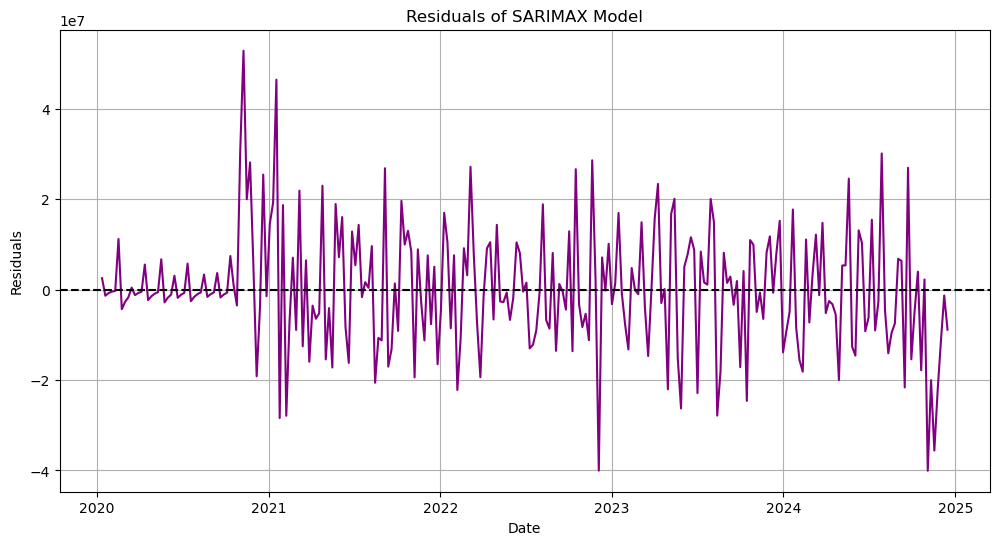

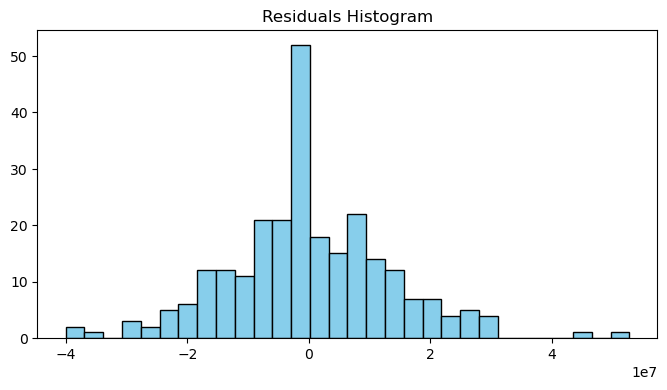

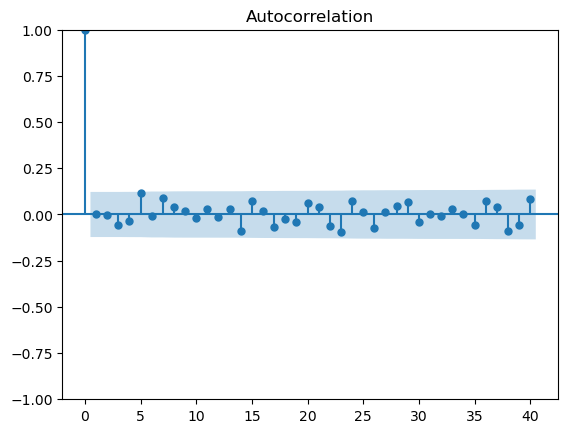

In [ ]:
# Get the fitted values (in-sample predictions)
fitted_values = model_fit.fittedvalues

# Calculate residuals (Actual - Fitted)
residuals = ts - fitted_values

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(residuals, color='purple')
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')  # Add a reference line at 0
plt.grid(True)
plt.show()

import statsmodels.api as sm

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Residuals Histogram')
plt.show()

# ACF Plot (to check autocorrelation of residuals)
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

1. Residuals Over Time (Top Plot)
    - This plot displays the residuals (errors) over time – the difference between the observed values and the predicted ones.
    - The residuals are centered around zero, which is good and suggests that the model captures the mean effectively. However, there are some large spikes (outliers), meaning that there are periods of poor prediction. The residuals should not show a clear pattern – the fluctuations here suggest some structure remains unexplained by the model.
2. Residuals Histogram (Middle Plot)
   - This is a distribution of the residuals. Ideally, they should be normally distributed around zero.
   - The histogram is approximately symmetric around zero, but it has long tails on both sides, indicating the presence of extreme errors (outliers). This suggests that the model mostly fits the data well but struggles with some unusual variations.
3. Autocorrelation of Residuals (Bottom Plot)
    - This plot checks if the residuals are correlated with their past values (lags). Ideally, residuals should show no autocorrelation, meaning that errors at one time point do not predict future errors.
    - Most lags fall within the blue confidence band, meaning no significant autocorrelation exists. This is a positive sign, indicating that the model captures the temporal patterns well and the residuals are random. If significant spikes were outside the band, it would suggest missing information in the model.


What do these mean?
- There is no significant autocorrelation, meaning the model has captured the time-dependent patterns effectively. There are large spikes in the residuals, meaning that the model is struggling with outliers or sudden changes. Residuals are not perfectly normal, meaning that we should consider transforming the data or adjusting the model parameters.

# ↓ FORECAST

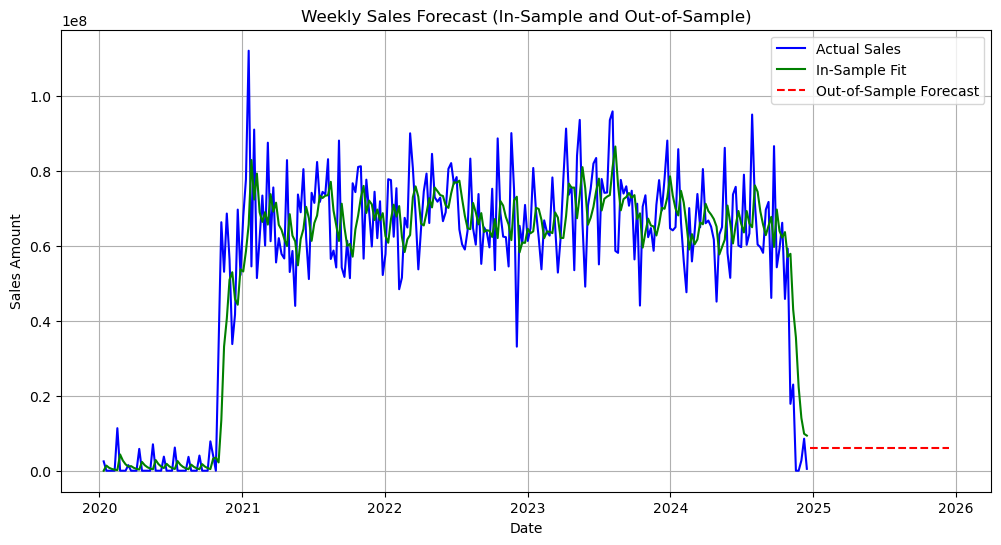

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
model = SARIMAX(ts, order=(0,1,1), seasonal_order=(0,0,0,52))  # Adjust your order if needed
model_fit = model.fit()

# In-sample predictions (from start to the end of actual data)
in_sample_preds = model_fit.predict(start=ts.index[0], end=ts.index[-1])

# Out-of-sample forecast (future predictions)
future_steps = 52  # Forecast for the next year (weekly data)
forecast = model_fit.forecast(steps=future_steps)

# Create date ranges for future
future_dates = pd.date_range(start=ts.index[-1], periods=future_steps+1, freq='W')[1:]

# Convert forecast into DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast})
forecast_df.set_index('Date', inplace=True)

# Plot the actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual Sales', color='blue')
plt.plot(in_sample_preds, label='In-Sample Fit', color='green')  # In-sample (historical) prediction
plt.plot(forecast_df, label='Out-of-Sample Forecast', linestyle='dashed', color='red')  # Future forecast

plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Weekly Sales Forecast (In-Sample and Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()


Since the suggested parameters by auto_arima presents a flat forecast and inconsistencies, alternative models were defined/tested to check for forecasting accuracy. Other models were also tested and still presented an almost flat and inaccurate graph.

With this, SARIMA (0,1,1)(1,1,0,52) is tested MANUALLY which is perfect in accounting for seasonality because of its seasonal order.

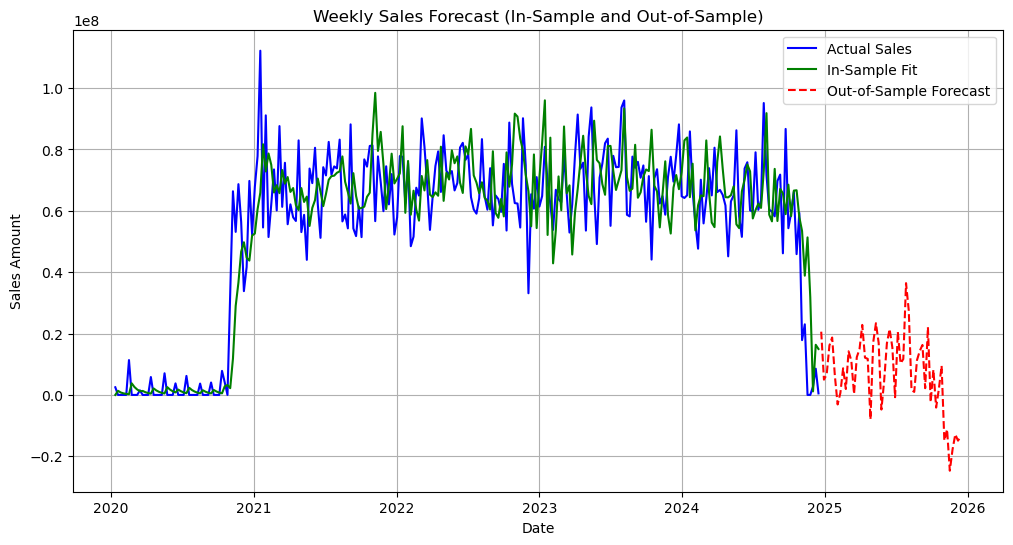

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model
model = SARIMAX(ts, order=(0,1,1), seasonal_order=(1,1,0,52))  # Adjust your order if needed
model_fit = model.fit()

# In-sample predictions (from start to the end of actual data)
in_sample_preds = model_fit.predict(start=ts.index[0], end=ts.index[-1])

# Out-of-sample forecast (future predictions)
future_steps = 52  # Forecast for the next year (weekly data)
forecast = model_fit.forecast(steps=future_steps)

# Create date ranges for future
future_dates = pd.date_range(start=ts.index[-1], periods=future_steps+1, freq='W')[1:]

# Convert forecast into DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast})
forecast_df.set_index('Date', inplace=True)

# Plot the actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Actual Sales', color='blue')
plt.plot(in_sample_preds, label='In-Sample Fit', color='green')  # In-sample (historical) prediction
plt.plot(forecast_df, label='Out-of-Sample Forecast', linestyle='dashed', color='red')  # Future forecast

plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Weekly Sales Forecast (In-Sample and Out-of-Sample)')
plt.legend()
plt.grid(True)
plt.show()


The latest model includes seasonal differencing (1,1,0,52), which means it accounts for seasonality more effectively by taking one seasonal difference (lag of 52 weeks). By including a seasonal AR term (1,1,0,52), the second model acknowledges past seasonal trends and adjusts predictions accordingly. The first model (0,0,0,52) does not account for seasonality properly, leading to a flat forecast.

Why Use This Order?
- (0,1,1): Standard differencing (1) makes the data stationary, and the MA(1) component helps correct short-term fluctuations.
- (1,1,0,52): Seasonal AR(1) accounts for yearly trends, seasonal differencing (1) removes seasonality, and no seasonal MA is included.
- Period = 52: Since the data is weekly, a full seasonal cycle is 52 weeks (1 year).

This model is enerally better if the data exhibits seasonal autoregressive behavior—meaning that past seasonal values influence the current value. This model captures long-term seasonal patterns better when future values are more dependent on past seasonal lags.

In [ ]:
print(forecast_df)

                Forecast
Date                    
2024-12-22  2.060900e+07
2024-12-29  4.974585e+06
2025-01-05  6.677040e+06
2025-01-12  1.611658e+07
2025-01-19  1.871768e+07
2025-01-26  6.110452e+06
2025-02-02 -3.096239e+06
2025-02-09  6.420092e+05
2025-02-16  8.688177e+06
2025-02-23  1.933801e+06
2025-03-02  1.422255e+07
2025-03-09  1.119870e+07
2025-03-16  3.348425e+05
2025-03-23  1.232132e+07
2025-03-30  1.492373e+07
2025-04-06  2.282272e+07
2025-04-13  1.213787e+07
2025-04-20  1.175493e+07
2025-04-27 -7.957279e+06
2025-05-04  1.709406e+07
2025-05-11  2.337077e+07
2025-05-18  1.693258e+07
2025-05-25 -4.761496e+06
2025-06-01  4.529586e+06
2025-06-08  1.680802e+07
2025-06-15  2.146974e+07
2025-06-22  1.548289e+07
2025-06-29 -7.414364e+05
2025-07-06  2.055161e+07
2025-07-13  1.030967e+07
2025-07-20  1.168292e+07
2025-07-27  3.643292e+07
2025-08-03  2.750422e+07
2025-08-10  1.592065e+06
2025-08-17  9.900713e+05
2025-08-24  1.132736e+07
2025-08-31  1.428839e+07
2025-09-07  1.628695e+07


# ↓ INSIGHTS

Recent Sales Decline:
- The actual sales data shows a sharp decline in late 2024. This suggests a significant drop in demand, supply chain disruptions, seasonality effects, or other external factors.

Forecasted Negative Values:
- The forecast predicts some negative values in late 2025, which is unrealistic for sales data. This may indicate an issue with the SARIMAX model, such as an inappropriate order selection, data anomalies, or seasonality misalignment.

Sales Volatility:
- The forecasted values exhibit high fluctuations, indicating uncertainty in future sales. This could suggest unstable market conditions or an ineffective model capturing trends properly.

# ↓ RECOMMENDATIONS

1. Develop Business Strategy
- Marketing & Sales Tactics
    - If demand is dropping, increase promotional activities, launch discounts, or improve loyalty programs.
    - Invest in digital marketing to expand brand awareness and attract new customers.
- Product & Service Optimization
    - Evaluate if certain products/services need enhancements or new features.
    - Consider diversifying the product line to mitigate reliance on declining categories.
- Competitive Benchmarking
    - Study competitors’ pricing, promotions, and market strategies.
    - Identify differentiation points to regain market share.

2. Optimize Operational Efficiency
- Financial Planning & Cost Control
    - Adjust budgeting & resource allocation to focus on high-impact activities.
    - Explore cost-cutting measures without compromising quality or customer satisfaction.
- Supply Chain & Inventory Management
    - If supply chain disruptions contributed to the decline, renegotiate contracts, find alternative suppliers, or improve logistics efficiency.
    - Reduce excess inventory if demand is genuinely slowing down.

3. Innovate & Explore New Revenue Streams
- Geographic & Market Expansion
    - Enter new markets or expand into untapped customer segments.
    - If domestic demand is weak, consider international expansion or e-commerce growth.
- New Product/Service Development
    - Identify emerging customer needs and develop products that align with changing demands.